<a href="https://colab.research.google.com/github/AlenaResiko/Project_curvature/blob/main/Estimate_discrete_curvature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating discrete Ricci-Olivier curvatrue from scalar curvature.

Code for estimating curvature on edges and at nodes for various 2d manifolds (Sphere, Flat torus, Poincare disk).

Last updated: Jan 5 2024.

Code by: Alena Chan.

Data used in this notebook (graphs and distance matrices) can be download from public folder:
https://drive.google.com/drive/folders/1JhEf7UaCuBpVkY3bTuwDwXYPZl1uqe43?usp=sharing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx # library for work with graph
import pickle # library for loading and saving objects in byte stream
# import statistics
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install Optimal Transport Library
!pip install POT
import ot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 822.7/822.7 kB 6.0 MB/s eta 0:00:00


## Functions

In [ ]:
""" Distribute uniform probabilities among vertices that are <= delta away from a node.

# Param:
D - distance matrix.
n1 - node at the center of ball to distribute probabilities among.
delta - radius of a ball.

# Return:
a [1 x n_points] array with distributed probabilities.
"""

def distribute_probabilities(D, n1, delta): # delta is ball radius - set it a bit greater than connection threshold
  probabilities = np.zeros(n_points)
  count = 0 # number of nodes inside a ball centered at n1 with radius delta
  for n2 in range(n_points):
    if D[n1][n2]<delta and n1!=n2:
      probabilities[n2] = 1
      count += 1
  if count>0:
    probabilities /= count # normalize probabilities
    return probabilities
  else:
      print("Error raised in distribute_probabilities. Node ", n1, " has degree 0.")
      return np.zeros(n_points)

In [ ]:
""" Find optimal transport (Wasserstein) distance between two nodes.

Param:
D - distance matrix.
n1, n2 - nodes to find distance between.

Return:
Wasserstein distance between n1 and n2.
"""

def findEdgeOTDist(D, n1, n2):
  if D[n1][n2] > epsilon: # nodes n1 and n2 are not connected by an edge
    return 0
  n1_prob = distribute_probabilities(D=D, n1=n1, delta=D[n1][n2]) # distribute probabilities around n1
  n2_prob = distribute_probabilities(D=D, n1=n2, delta=D[n1][n2]) # distribute probabilities around n2
  if n1_prob.any() and n2_prob.any(): # if both distributions are non-zero
    return ot.emd2(n1_prob, n2_prob, D) # use POT library to find optimal transport distance
  else: # either probability distribution is zero, i.e., n1 is the only node in a ball around n2 or vice versa
    print("Error raised in findEdgeOTDist. Tried to compute optimal transport dist over nodes with 0 probabilities.")
    return 0

In [ ]:
""" Find scalar curvature of a random sample of edges in a graph.

Param:
count - number of edges in a sample.
n_points - number of points in a graph.
G - graph of manifold.
D - distance matrix.

Return:
[n_points x n_points] array with curvatures calculated for a sample of edges.
"""

def curvature_random_edges(count, n_points, G, D):
  edge_curvatures = np.zeros((n_points, n_points))
  for _ in range(count):
    n1 = random.randint(0, n_points)
    ind = random.randint(0, G.degree(n1)-1)
    n2 = list(G.neighbors(n1))[ind] # choose random neighbor of n1
    Wd = findEdgeOTDist(D=D, n1=n1, n2=n2) # find Wasserstein distance
    if Wd != 0:
      print("Wasserstein distance: ", Wd)
      print("Geodesic distance: ", D[n1][n2])
      edge_curvatures[n1][n2] = 1 - Wd/D[n1][n2]
      print("Curvature of edge between " + str(n1) + " and " + str(n2) + " is " + str(edge_curvatures[n1][n2]))
  return edge_curvatures

In [ ]:
""" Plot histogram of curvature of sampled edges. """

def display_curvatures(c):
  c_processed = c.flatten()
  data = c_processed[np.where(c_processed!=0)] # get all non-0 values
  plt.hist(data, bins=30, color='skyblue', edgecolor='black')
  plt.xlabel('Curvatures')
  plt.ylabel('Frequency')
  plt.title('Scalar curvatures histogram')
  plt.show()

  print("Stats: ")
  print("Sampled ", len(data), " edges.")
  print("Mean: ", data.mean())
  print("Std: ", data.std())

In [ ]:
""" Appoximate discrete curvature of a given node in a graph using curvature of its connected edges.

Param:
G - graph of manifold.
D - distance matrix.
n1 - node to approximate curvature at.
nodes_per_node - number of neighbors sampled. If not specified, use all neighbors.

Return:
Averaged approximation of discrete curvature.
"""

def curvature_random_nodes(G, D, n1, nodes_per_node=-1):
  curvature_edges_n1 = np.zeros(len(G.nodes)) # n_points x 1

  if nodes_per_node < 0 or nodes_per_node >= G.degree(n1):
    sampled_n2 = G.neighbors(n1)
  else:
    sampled_n2 = random.sample(range(0, G.degree(n1)), nodes_per_node)

  for n2 in sampled_n2:
    Wd = findEdgeOTDist(D, n1, n2)
    if Wd != 0:
      curvature_edges_n1[n2] = 1 - Wd/D[n1][n2]
    else:
      curvature_edges_n1[n2] = 0

  av = curvature_edges_n1.sum() / (curvature_edges_n1!=0).sum()
  return av

In [ ]:
""" Plot histogram of curvature of sampled nodes. """

def display_node_curvatures(curvature_nodes): # curvature_nodes is a 1 x n_points nparray
  data = np.array([x for x in curvature_nodes if(((x != 0) & (str(x) != 'nan')).all())])
  plt.hist(data, bins=30, color='skyblue', edgecolor='black')
  plt.xlabel('Curvatures on nodes')
  plt.ylabel('Frequency')
  plt.title('Discrete curvatures histogram')
  plt.show()

  print("Stats: ")
  print("Sampled ", len(data), " nodes.")
  print("Mean: ", data.mean())
  print("Std: ", data.std())

## Applications

#### Sphere

In [ ]:
# hyperparameters used for sampling

n_points = 3162 # number of points sampled
epsilon = 1/n_points**(0.16) # connection threshold
print(n_points, epsilon)

3162 0.2754267398412311


In [ ]:
# load graph
G_S = pickle.load(open("/content/drive/MyDrive/Curvature Project/Graphs_0/G_S_2d.pickle", 'rb'))
print("G loaded - ", G_S)
# load distance matrix
D_S = np.load('/content/drive/MyDrive/Curvature Project/Graphs_0/D_S_2d.npy')
print("D loaded - ", D_S)

G loaded -  Graph with 3162 nodes and 94299 edges
D loaded -  [[0.         0.95480812 0.86371887 ... 2.37759782 1.50053148 2.21196589]
 [0.95480812 0.         0.60239247 ... 2.84372703 1.62959806 1.26551939]
 [0.86371887 0.60239247 0.         ... 2.37917726 1.04868747 1.45847948]
 ...
 [2.37759782 2.84372703 2.37917726 ... 0.         1.33394139 1.63568555]
 [1.50053148 1.62959806 1.04868747 ... 1.33394139 0.         1.58569016]
 [2.21196589 1.26551939 1.45847948 ... 1.63568555 1.58569016 0.        ]]


In [ ]:
count = 300
c = curvature_random_edges(count=count, n_points=n_points, G=G_S, D=D_S)

Wasserstein distance:  0.24842946259287307
Geodesic distance:  0.24660549043235253
Curvature of edge between 1563 and 3038 is -0.00739631610522018
Wasserstein distance:  0.09922486785618197
Geodesic distance:  0.1176363624640146
Curvature of edge between 213 and 2529 is 0.15651193408385755
Wasserstein distance:  0.276824329237293
Geodesic distance:  0.257865306288491
Curvature of edge between 2570 and 2654 is -0.07352296911004874
Wasserstein distance:  0.34782069593832476
Geodesic distance:  0.2560561323490095
Curvature of edge between 2985 and 3042 is -0.35837674633091154
Wasserstein distance:  0.20152519714293426
Geodesic distance:  0.216108143086552
Curvature of edge between 2690 and 2446 is 0.06747985399965795
Wasserstein distance:  0.06965186307541352
Geodesic distance:  0.055596113388588934
Curvature of edge between 1668 and 994 is -0.2528189261825182
Wasserstein distance:  0.20300089343988467
Geodesic distance:  0.21865212553415775
Curvature of edge between 449 and 1943 is 0.071

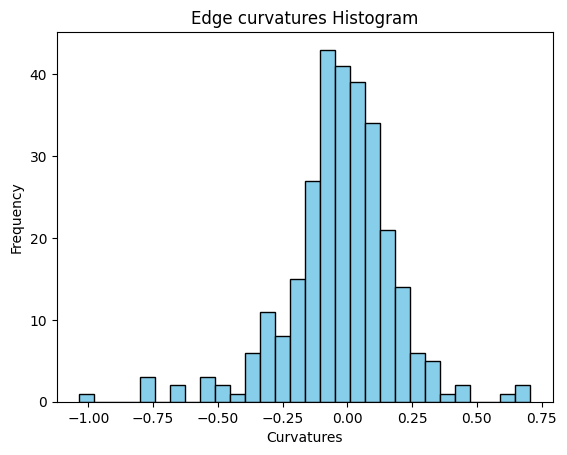

Stats: 
Sampled  288  edges.
Mean:  -0.027313455500113857
Std:  0.2123838208190802


In [ ]:
display_curvatures(c)

In [ ]:
### compute curvature at nodes
curvature_nodes = np.zeros(n_points)
for i in range(100):
  curvature_nodes[i] = curvature_random_nodes(G=G_S, D=D_S, n1=i)
  print(curvature_nodes[i], " - node ", i)
print(curvature_nodes)

Node  1480  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
Node  0  has degree 0.
Node  1662  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
-0.05667508653431093  - node  0
Node  1  has degree 0.
Node  70  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
Node  1585  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
Node  3033  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
0.08643284364896892  - node  1
Node  2  has degree 0.
Node  937  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
Node  3043  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
-0.028153473478895748  - node  2
Node  3  has degree 0.
Node  1405  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
-0.10503567047655613  - node  3
Node  4  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
-0.015063477117537596  - node  4
Node  5  has degree 0.
T

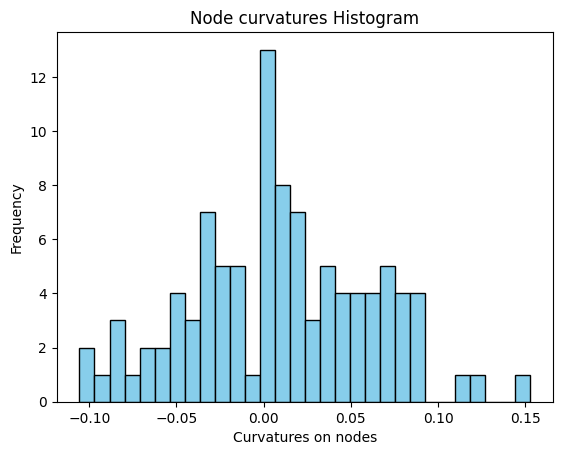

Stats: 
Sampled  100  nodes.
Mean:  0.0098042828033711
Std:  0.05182695752431819


In [ ]:
display_node_curvatures(curvature_nodes)

#### Flat Torus

In [ ]:
# hyperparameters used for sampling

n_points = 3162 # number of points sampled
epsilon = 1/n_points**(0.16) # connection threshold
print(n_points, epsilon)

3162 0.2754267398412311


In [ ]:
# load graph
G_FT = pickle.load(open("/content/drive/MyDrive/Curvature Project/Graphs_0/G_FT.pickle", 'rb'))
print("G loaded", G_FT)
# load distance matrix
D_FT = np.load('/content/drive/MyDrive/Curvature Project/Graphs_0/D_FT.npy')
print("D loaded - ", D_FT)

G loaded Graph with 3162 nodes and 1190613 edges
D loaded -  [[0.         0.4067369  0.36518773 ... 0.65806853 0.35885055 0.29122129]
 [0.4067369  0.         0.42252431 ... 0.30894379 0.28006836 0.30679959]
 [0.36518773 0.42252431 0.         ... 0.32499448 0.14928871 0.12304432]
 ...
 [0.65806853 0.30894379 0.32499448 ... 0.         0.44901266 0.44675745]
 [0.35885055 0.28006836 0.14928871 ... 0.44901266 0.         0.07675087]
 [0.29122129 0.30679959 0.12304432 ... 0.44675745 0.07675087 0.        ]]


In [ ]:
count = 300
c2 = curvature_random_edges(count=count, n_points=n_points, G=G_FT, D=D_FT)

NameError: ignored

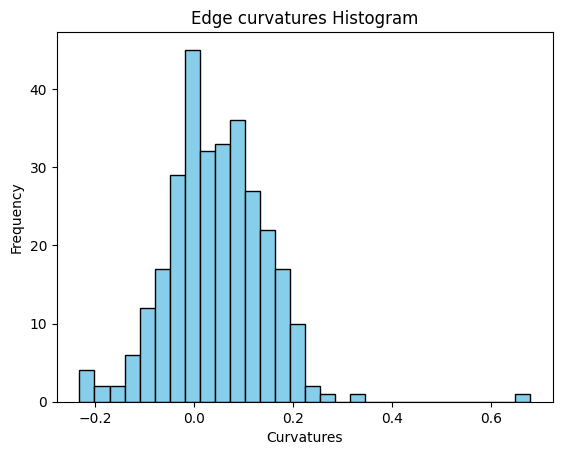

Stats: 
Sampled  299  edges.
Mean:  0.04458710009461343
Std:  0.09976101907182845


In [ ]:
display_curvatures(c2)

In [ ]:
### compute curvature at nodes
curvature_nodes = np.zeros(n_points)
for i in range(100):
  curvature_nodes[i] = curvature_random_nodes(G=G_FT, D=D_FT, n1=i, nodes_per_node=30)
  print(curvature_nodes[i], " - node ", i)

0.6448209639746207  - node  0
0.7179860319820206  - node  1
0.7387733815424583  - node  2
0.6926452998838052  - node  3
0.8349486397027144  - node  4
0.6102797496772243  - node  5
0.7789636699758222  - node  6
Node  7  has degree 0.
Node  7  has degree 0.
Tried to compute edge over nodes with 0 probabilities.


<ipython-input-17-87fcf7c94f4d>:11: RuntimeWarning: invalid value encountered in double_scalars
  curvature_edges_n1[n2] = 1 - Wd/D[n1][n2]


nan  - node  7
0.7815748106202807  - node  8
0.8013380610173371  - node  9
0.9031361141039692  - node  10
0.7710539135808858  - node  11
0.8350287951090277  - node  12
0.7106627193554113  - node  13
0.6603206081939267  - node  14
0.7434315150795181  - node  15
0.683421827257502  - node  16
0.6782820111988386  - node  17
0.744331827197284  - node  18
0.8732585421968809  - node  19
0.8305359918209575  - node  20
0.8733606184820923  - node  21
0.8400085916076797  - node  22
0.8090208291392197  - node  23
0.8247996549796551  - node  24
0.7384924744397107  - node  25
0.7517470183635566  - node  26
Node  27  has degree 0.
Node  27  has degree 0.
Tried to compute edge over nodes with 0 probabilities.
nan  - node  27
0.7377311159119413  - node  28
0.7390555916369689  - node  29
0.772735525700443  - node  30
0.7110600345705662  - node  31
0.6285919107128084  - node  32
0.7089175558821663  - node  33
0.8137513906926794  - node  34
0.7725338361450027  - node  35
0.7864678986988274  - node  36
Nod

NameError: ignored

In [ ]:
print(curvature_nodes[:100])

[0.64482096 0.71798603 0.73877338 0.6926453  0.83494864 0.61027975
 0.77896367        nan 0.78157481 0.80133806 0.90313611 0.77105391
 0.8350288  0.71066272 0.66032061 0.74343152 0.68342183 0.67828201
 0.74433183 0.87325854 0.83053599 0.87336062 0.84000859 0.80902083
 0.82479965 0.73849247 0.75174702        nan 0.73773112 0.73905559
 0.77273553 0.71106003 0.62859191 0.70891756 0.81375139 0.77253384
 0.7864679         nan 0.58342354 0.68963237 0.83082346 0.68454512
 0.76196401 0.68856752 0.72295796 0.82564633 0.87728038 0.86961706
 0.78903611 0.69776222 0.75113976 0.70554855 0.813543   0.90362185
 0.63058233 0.7778519  0.75054266 0.73873762 0.90204495 0.79919083
 0.78897872 0.81892771        nan 0.81029428 0.81785981 0.67788267
 0.87343471 0.81913127        nan 0.79035612 0.8104408  0.67909556
 0.7411842  0.7063879  0.70692088 0.77088919 0.74435372 0.77075156
 0.74598168 0.80203523 0.86533031 0.73920572 0.72106226 0.67140903
 0.73725811 0.74464347 0.73761094 0.84986132 0.75334359 0.8053

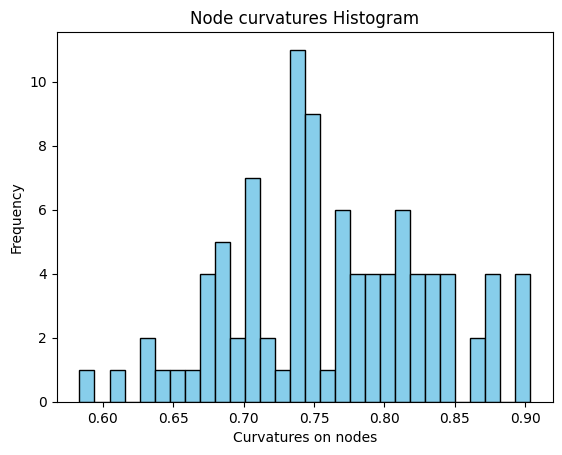

Stats: 
Sampled  95  nodes.
Mean:  0.7631322561903843
Std:  0.06996139906842994


In [ ]:
display_node_curvatures(curvature_nodes)

#### Poincare disk

In [ ]:
# hyperparameters used for sampling

n_points = 3162 # number of points sampled
epsilon = 1/n_points**(0.16) # connection threshold
print(n_points, epsilon)

10000 0.2290867652767773


In [ ]:
# load graph
G_P = pickle.load(open("/content/drive/MyDrive/Curvature Project/Graphs_0/G_P_10000.pickle", 'rb'))
print("G loaded - ", G_P)
# load distance matrix
D_P = np.load('/content/drive/MyDrive/Curvature Project/Graphs_0/D_P_10000.npy')
print("D loaded - ", D_P)

G loaded -  Graph with 10000 nodes and 2193145 edges
D loaded -  [[0.         1.07346222 1.2341758  ... 1.6909365  1.21734802 1.54532823]
 [1.07346222 0.         0.41460042 ... 0.62488281 0.38177256 1.01654571]
 [1.2341758  0.41460042 0.         ... 0.62699677 0.03291857 0.62169823]
 ...
 [1.6909365  0.62488281 0.62699677 ... 0.         0.61340029 1.16586657]
 [1.21734802 0.38177256 0.03291857 ... 0.61340029 0.         0.65279186]
 [1.54532823 1.01654571 0.62169823 ... 1.16586657 0.65279186 0.        ]]


In [ ]:
count = 300
c3 = curvature_random_edges(count=count, n_points=n_points, G=G_P, D=D_P)

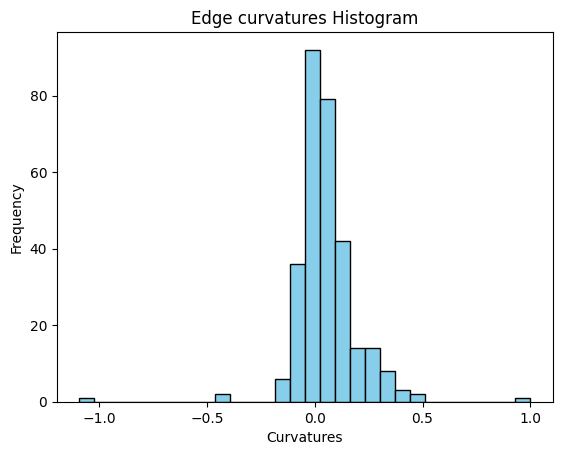

Stats: 
Sampled  300  edges.
Mean:  0.051744522099187715
Std:  0.14741945148331898


In [ ]:
display_curvatures(c)

#### Poincare using center points

Approximated discrete curvature of random points on the Poincare disk appear inaccurate, probably because of incorrect distance calculation near boundaries. Therefore, we only look at points near the origin.

In [ ]:
# find positions of points located close to the origin

list_of_central_points = []

positions = nx.get_node_attributes(G_P, "point_position") # load positions from graph

for i in range(len(positions)):
  d = math.sqrt((positions[i][0])**2 + (positions[i][1])**2) # find distance form the origin
  if d < 0.08: # only choose points that are <= 0.08 away from thr center
    list_of_central_points.append(i)

list_of_central_points

In [ ]:
""" Find scalar curvature of a random sample of edges in a graph of Poincare Disk.

Param:
n_points - number of points in a graph.
G - graph of manifold.
D - distance matrix.

Return:
[n_points x n_points] array with curvatures calculated for a sample of edges.
"""

def curvature_random_edges_poincaredisk(n_points, G, D):
  edge_curvatures = np.zeros((n_points, n_points))
  for n1 in list_of_central_points:
    ind = random.randint(0, G.degree(n1)-1)
    n2 = list(G.neighbors(n1))[ind] # find all neighbors
    Wd = findEdgeOTDist(D=D, n1=n1, n2=n2)
    print("Wasserstein distance: ", Wd)
    print("Geodesic distance: ", D[n1][n2])
    edge_curvatures[n1][n2] = 1 - Wd/D[n1][n2]
    print("Curvature of edge between " + str(n1) + " and " + str(n2) + " is " + str(edge_curvatures[n1][n2]))
  return edge_curvatures

In [ ]:
c3 = curvature_random_edges_poincaredisk(n_points=n_points, G=G_P, D=D_P)

Wasserstein distance:  0.2313308083275049
Geodesic distance:  0.22386196534355765
Curvature of edge between 7 and 9088 is -0.03336360856336151
Wasserstein distance:  0.07777637928247223
Geodesic distance:  0.07956241579389296
Curvature of edge between 9 and 2072 is 0.022448243854830574
Wasserstein distance:  0.12760466332236894
Geodesic distance:  0.11350938208535893
Curvature of edge between 147 and 1005 is -0.12417723520343338
Wasserstein distance:  0.18657527572798946
Geodesic distance:  0.1959320682142747
Curvature of edge between 162 and 4500 is 0.04775528871594659
Wasserstein distance:  0.17942262409892024
Geodesic distance:  0.18782689459906893
Curvature of edge between 230 and 4364 is 0.04474476628114554
Wasserstein distance:  0.08843768008726478
Geodesic distance:  0.09368667382241681
Curvature of edge between 261 and 2457 is 0.05602711165839336
Wasserstein distance:  0.2130909762302956
Geodesic distance:  0.22005903969483948
Curvature of edge between 307 and 2850 is 0.0316645

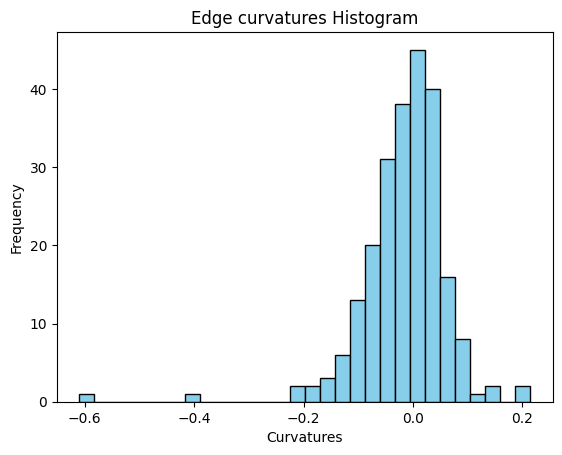

Stats: 
Sampled  231  edges.
Mean:  -0.015021149035797042
Std:  0.0794416107000866


In [ ]:
display_curvatures(c3)

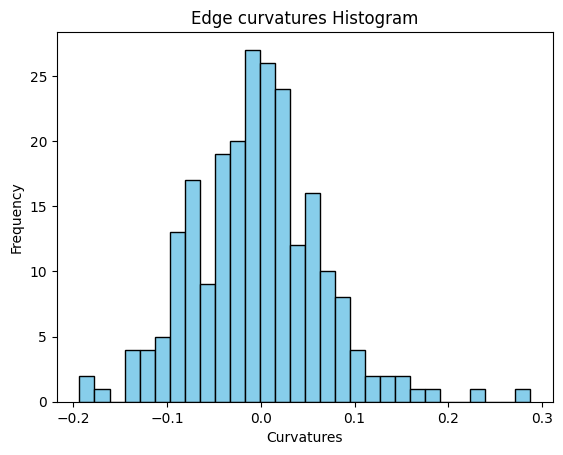

Stats: 
Sampled  231  edges.
Mean:  -0.004098989615428881
Std:  0.06869242742710843


In [ ]:
display_curvatures(c)

In [ ]:
list_for_nodes_curvature = list_of_central_points

In [ ]:
 ### compute curvature at nodes
curvature_nodes = np.zeros(n_points)
count = 1
for n1 in list_for_nodes_curvature:
  print(count)
  curvature_nodes[n1] = curvature_random_nodes(G=G_P, D=D_P, n1=n1, nodes_per_node=50)
  print(curvature_nodes[n1], " - node ", n1)
  count+=1

1
0.03474688990563379  - node  7
2
-0.06705519114543768  - node  9
3
-0.024514542589135935  - node  147
4
-0.00944628594109842  - node  162
5
0.02676915473860475  - node  230
6
nan  - node  261
7


<ipython-input-31-6ef08b9de613>:16: RuntimeWarning: invalid value encountered in double_scalars
  av = curvature_edges_n1.sum() / (curvature_edges_n1!=0).sum()


-0.02523779362069961  - node  307
8
-0.025237329222367672  - node  463
9
-0.10612415252379775  - node  505
10
0.037478179867143635  - node  515
11
-0.011254893010146927  - node  587
12
-0.02909758131428064  - node  590
13
-0.23454441533360804  - node  626
14
0.00956026230886157  - node  656
15
-0.09041290026338167  - node  718
16
-0.084334048518097  - node  774
17
0.040338232536611285  - node  812
18
nan  - node  863
19
0.01190074826918038  - node  874
20
0.013025614683719322  - node  921
21
-0.016636047236505858  - node  930
22
-0.02478877942657043  - node  934
23
-0.042489714506170395  - node  990
24
0.07216674427327435  - node  1002
25
0.0030164418925292167  - node  1028
26
0.05102318590520791  - node  1057
27
0.0032775149182329155  - node  1060
28
nan  - node  1094
29
0.038596043639525957  - node  1104
30
0.06370086812288234  - node  1131
31
nan  - node  1151
32
-0.01799478901368075  - node  1160
33
-0.02596217474352558  - node  1231
34
-0.0025847434622632837  - node  1316
35
nan  

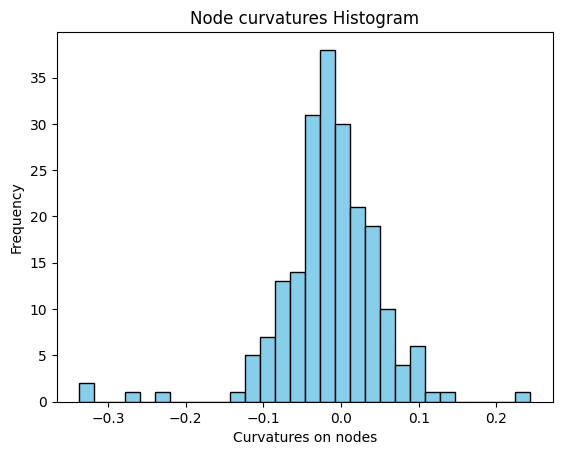

Stats: 
Sampled  206  nodes.
Mean:  -0.013097012053341996
Std:  0.0649574196746011


In [ ]:
display_node_curvatures(curvature_nodes)